In [57]:
import numpy as np

from keras.models import Sequential
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

import matplotlib.pyplot as plt
from keras.preprocessing import image
from mtcnn.mtcnn import MTCNN

import cv2

In [2]:
from inception_resnet_v1 import *
model = InceptionResNetV1Norm(classes=512)
model.load_weights('facenet/weight.h5')

In [71]:
def read_image(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def crop_bb(image, detection, margin):
    x1, y1, w, h = detection['box']
    x1 -= margin
    y1 -= margin
    w += 2*margin
    h += 2*margin
    if x1 < 0:
        w += x1
        x1 = 0
    if y1 < 0:
        h += y1
        y1 = 0
    return image[y1:y1+h, x1:x1+w]

def crop(mtcnn, img):
    det = mtcnn.detect_faces(img)[0]
    margin = int(0.1 * img.shape[0])
    ret = crop_bb(img, det, margin)
    return ret

def pre_process(face, required_size=(160, 160)):

    ret = cv2.resize(face, required_size)
    #ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    ret = ret.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = ret.mean(), ret.std()
    ret = (ret - mean) / std

    return ret

In [56]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(160, 160))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [92]:
metric = "euclidean" #euclidean or cosine

threshold = 0
if metric == "euclidean":
    threshold = 0.9
elif metric == "cosine":
    threshold = 0.035

def verifyFace(img1, img2):
    #produce 128-dimensional representation
    img1_representation = model.predict(pre_process(crop(mtcnn,img1)).reshape(1,160,160,3))[0,:]
    img2_representation = model.predict(pre_process(crop(mtcnn,img2)).reshape(1,160,160,3))[0,:]
    
    
    if metric == "euclidean":
        img1_representation = img1_representation
        img2_representation = img2_representation

        euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
        print("euclidean distance (l2 norm): ",euclidean_distance)

        if euclidean_distance < threshold:
            print("verified... they are same person")
        else:
            print("unverified! they are not same person!")
            
    elif metric == "cosine":
        cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
        print("cosine similarity: ",cosine_similarity)

        if cosine_similarity < 0.07:
            print("verified... they are same person")
        else:
            print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(img1)
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(img2)
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

euclidean distance (l2 norm):  0.80556357
verified... they are same person


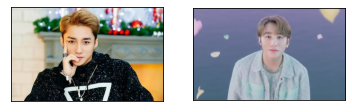

-----------------------------------------


In [93]:
img1 = read_image("t10.jpg")
img2 = read_image("t11.jpg")
mtcnn = MTCNN()
verifyFace(img1, img2)